In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_ideal_probability(n, FSR, A, resolution):
    # 2^N is the total number of codes
    num_codes = 2 ** resolution
    
    # Calculate arguments for arcsin and clamp within [-1, 1] to avoid invalid values
    x1 = FSR * ((n - 2**(resolution - 1)) / (A * num_codes))
    x2 = FSR * ((n - 1 - 2**(resolution - 1)) / (A * num_codes))
    
    # Clamp values to the range [-1, 1] for valid arcsin input
    x1 = np.clip(x1, -1, 1)
    x2 = np.clip(x2, -1, 1)
    
    # Calculate P(n) based on the sinusoidal input model
    P_n = (1 / np.pi) * (np.arcsin(x1) - np.arcsin(x2))
    return P_n

def calculate_dnl(histogram, codes, FSR, A, resolution):
    # Calculate ideal probability (IP) for each code
    p_n = np.array([calculate_ideal_probability(n, FSR, A, resolution) for n in codes])
    
    # Actual hits per code (AP) from the histogram
    actual_hits = histogram
    
    # Calculate DNL as (AP / IP) - 1
    dnl = (actual_hits / (total_hits* p_n)) - 1
    
    return dnl

def calculate_inl(dnl):
    # Calculate INL by accumulating DNL values
    inl = np.cumsum(dnl)
    return inl

# Load histogram data from Excel file and remove zeros
def load_histogram_from_excel(file_path):
    # Read the Excel file
    df = pd.read_excel(file_path)

    # Filter rows to include only codes between 50 and 65534
    df = df[(df.iloc[:, 0] >= 50) & (df.iloc[:, 0] <= 65534)]
    
    # Remove rows where the second column (hits) is zero
    df = df[df.iloc[:, 1] != 0]
    
    # Extract 'n' and 'hits' columns as numpy arrays
    codes = df.iloc[:, 0].to_numpy()  # First column for n values
    histogram = df.iloc[:, 1].to_numpy()  # Second column for hits
    
    return codes, histogram

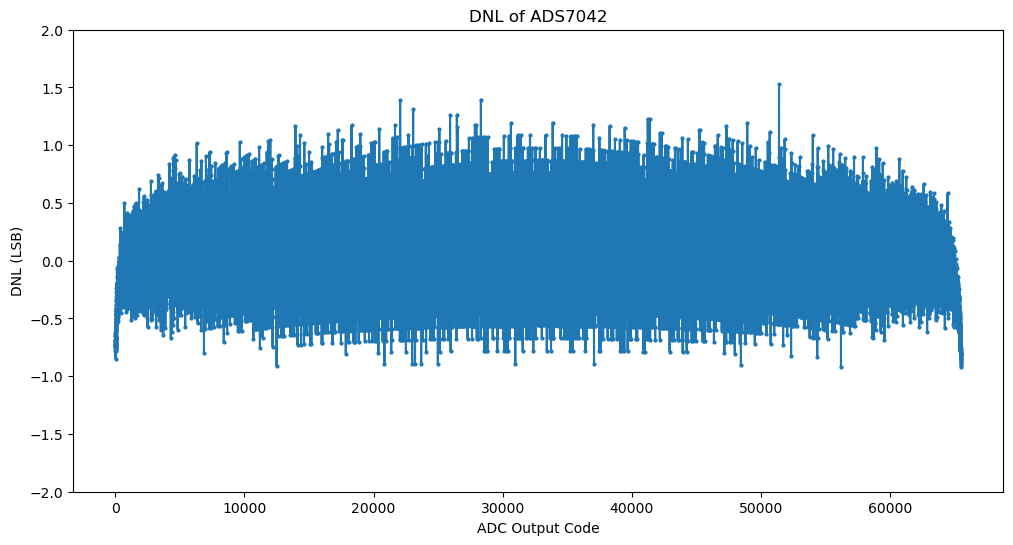

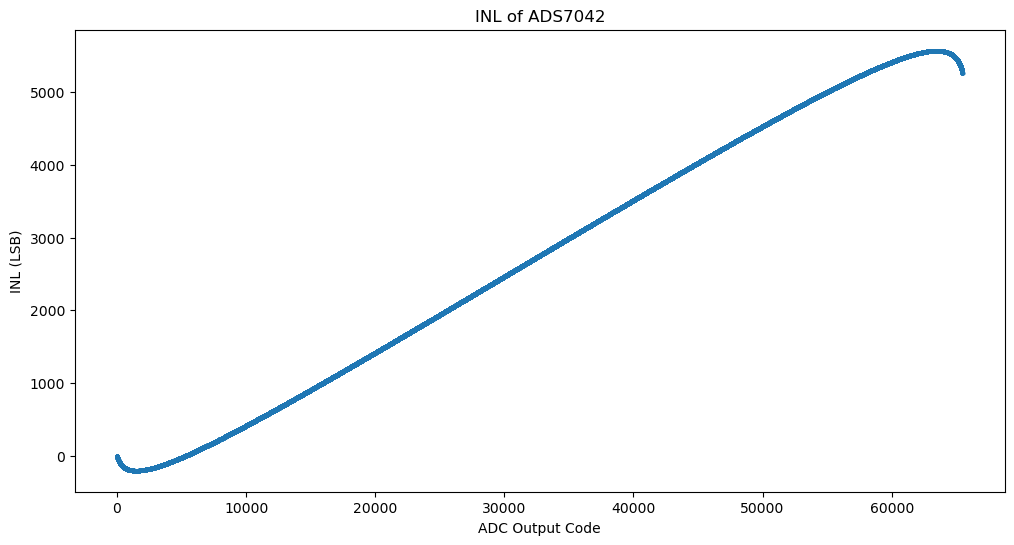

In [13]:
# Parameters
file_path = "800.xlsx"  # Filename in the same directory as your code
resolution = 16     # Set to 16 for a 16-bit ADC
FSR = 5.0           # Full scale range of the ADC in volts
A = FSR / 2         # Amplitude of the input sinusoidal signal
# offset = 2.49    # Offset to be applied to the input model

# Load histogram data from Excel
codes, histogram = load_histogram_from_excel(file_path)
total_hits = np.sum(histogram)

# Calculate DNL and INL
dnl = calculate_dnl(histogram, codes, FSR, A, resolution)
inl = calculate_inl(dnl)

# Plot and save DNL
plt.figure(figsize=(12, 6))
plt.plot(dnl, marker='o', linestyle='-', markersize=2)   
plt.title('DNL of ADS7042')
plt.xlabel('ADC Output Code')
# plt.xlim(50, 65534)
plt.ylim(-2, 2)
plt.ylabel('DNL (LSB)')
plt.savefig("DNL_800Hz_AFG.png")  # Save as DNL.png in the current directory

# Plot and save INL
plt.figure(figsize=(12, 6))
plt.plot(inl, marker='o', linestyle='-', markersize=2)   
plt.title('INL of ADS7042')
plt.xlabel('ADC Output Code')
plt.ylabel('INL (LSB)')
# plt.xlim(50, 65534)
plt.savefig("INL_800Hz_AFG.png")  # Save as INL.png in the current directory

plt.show()